Agent A: Ingestion

In [11]:
from langgraph.graph import StateGraph, START, END, MessagesState
import os, json
from typing import Dict, List, Any
import pandas as pd
from paperscraper.pubmed import get_and_dump_pubmed_papers

class State(MessagesState):
    customer_name: str
    my_age: int
    pubmed_data: List[Dict[str, Any]] = None
    csv_path: str = "data/raw/pubmed_raw.csv"
    csv_out_path: str = "data/processed/pubmed_processed.csv"

state: State = {}
state["customer_name"] = "Joan"
customer_name = state.get("customer_name", None)
print(customer_name)

Joan


Helpers

In [12]:
def _normalize_query(q: Any) -> List[List[str]]:
    """
    paperscraper expects a list of "term-groups", where terms in the same sublist are OR'ed,
    and sublists are AND'ed. E.g., [['diabetes'], ['machine learning', 'deep learning']]
    """
    if q is None:
        # Default: something broad but medical—adjust this later from Agent B or user input
        return [["clinical"], ["machine learning"]]
    if isinstance(q, str):
        return [[q]]
    if isinstance(q, list) and all(isinstance(x, str) for x in q):
        return [q]
    if isinstance(q, list) and all(isinstance(x, list) for x in q):
        return q
    # Fallback
    return [[str(q)]]

def _jsonl_to_df(jsonl_path: str, cap: int = 50) -> pd.DataFrame:
    rows: List[Dict[str, Any]] = []
    with open(jsonl_path, "r", encoding="utf-8") as f:
        for i, line in enumerate(f):
            if i >= cap:
                break
            try:
                rec = json.loads(line)
            except Exception:
                continue

            rows.append({
                "pmid": rec.get("pmid") or rec.get("PMID"),
                "doi": rec.get("doi") or rec.get("DOI"),
                "title": rec.get("title") or rec.get("Title"),
                "abstract": rec.get("abstract") or rec.get("Abstract"),
                "journal": rec.get("journal") or rec.get("Journal"),
                "year": rec.get("year") or rec.get("publication_year") or rec.get("Year"),
                "authors": rec.get("authors"),
                "keywords": rec.get("keywords"),
                "citation_count": rec.get("citation_count"),
                "source": rec.get("source") or "PubMed",
                "url": rec.get("url") or rec.get("link"),
            })
    return pd.DataFrame(rows)


In [13]:
def fetch_data(state: State) -> State:
    """
    Retrieve ~50 PubMed records via paperscraper and drop a temporary JSONL dump on disk.
    """
    q = _normalize_query(state.get("pubmed_query", None))
    dump_path = state.get("tmp_dump_path") or "data/tmp/pubmed_dump.jsonl"
    os.makedirs(os.path.dirname(dump_path), exist_ok=True)
    get_and_dump_pubmed_papers(q, output_filepath=dump_path)

    state["tmp_dump_path"] = dump_path
    return state


In [14]:
def persist(state: State) -> State:
    """
    Read the JSONL dump, cap to ~50, and persist to CSV at data/raw/pubmed_raw.csv.
    """
    dump_path = state.get("tmp_dump_path", "data/tmp/pubmed_dump.jsonl")
    csv_out = state.get("csv_out_path") or "data/raw/pubmed_raw.csv"
    cap = int(state.get("max_records", 50))

    df = _jsonl_to_df(dump_path, cap=cap)

    os.makedirs(os.path.dirname(csv_out), exist_ok=True)
    df.to_csv(csv_out, index=False, encoding="utf-8")

    state["csv_out_path"] = csv_out
    state["pubmed_rows"] = len(df)
    state["messages"] = state.get("messages", []) + [
        {"role": "system", "content": f"Ingestion complete: {len(df)} rows → {csv_out}"}
    ]
    return state

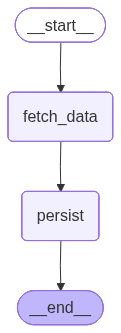

In [15]:
from langgraph.graph import StateGraph, START, END


builder = StateGraph(State)
builder.add_node("fetch_data", fetch_data)
builder.add_node("persist", persist)

builder.add_edge(START, "fetch_data")
builder.add_edge("fetch_data", "persist")
builder.add_edge("persist", END)

agent = builder.compile()
from IPython.display import Image, display
display(Image(agent.get_graph().draw_mermaid_png()))

In [17]:
state: State = {}
state["customer_name"] = "Joan"
state["my_age"] = 24
state["pubmed_query"] = [["PubMed", "biomedical"], ["colombia"]]
state["max_records"] = 50
state["tmp_dump_path"] = "data/tmp/pubmed_dump.jsonl"
state["csv_out_path"] = "data/raw/pubmed_raw.csv"

result = agent.invoke(state)
print("Wrote:", result["csv_out_path"], "| rows:", result.get("pubmed_rows"))

Wrote: data/raw/pubmed_raw.csv | rows: None
